combination of all three : feature reconstruction loss, constrastive loss and distance cross entropy loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 10.1 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 216, done.
remote: Counting objects:

---

In [ ]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [ ]:
import os
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-151b9d639ad9>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1",
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D embeddings',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 20,
    "batch_size": 64,
    # model configs
    "d_model": 128,
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21,
    "overlap": 4.21,
    "seq_len": 20,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [ ]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [ ]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [ ]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [ ]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [ ]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0.1)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

---

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [ ]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [ ]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [ ]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def shuffledTripletLoss(pred_feat, sem_space, y, bs=32, loss_fn=nn.TripletMarginLoss(margin=0.1, p=2, reduction='none')):
    anchor_feat = sem_space[y, ...]
    neg_feat = torch.concat([anchor_feat[bs//2:, ...], anchor_feat[:bs//2, ...]], dim=0).squeeze()
    pos_feat = anchor_feat.squeeze()

    neg_y = torch.concat([y[bs//2:], y[:bs//2]])
    y_mask = (y!=neg_y).long()

    output_arr = loss_fn(pred_feat, pos_feat, neg_feat)
    masked_arr = torch.multiply(output_arr, y_mask)

    output = masked_arr.mean()
    return output

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [ ]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output, targets.squeeze(), random_selected_feat, loss_fn =loss_module['class'] )
                const_loss = shuffledTripletLoss(feat_output, random_selected_feat, targets, loss_fn=loss_module["constrastive"])
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss + loss_alpha*const_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [ ]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                const_loss = shuffledTripletLoss(feat_output, random_selected_feat, targets, loss_fn=loss_module["constrastive"])
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss + loss_alpha*const_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']

    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v)

In [ ]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-126


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.378



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.619



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.801



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.851



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.902



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.907



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.922



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.936



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.956



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.961



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.961



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.967



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.965



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.966



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.969



unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

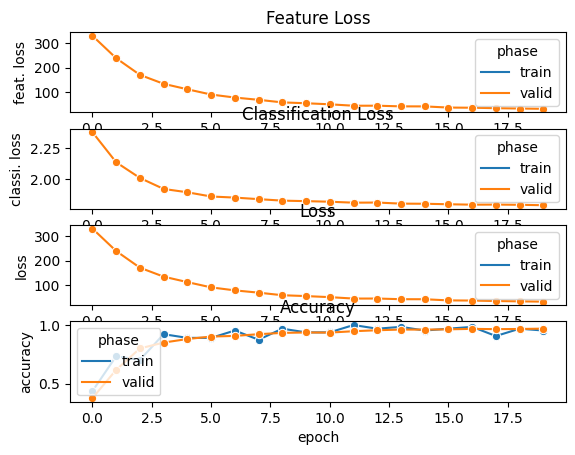

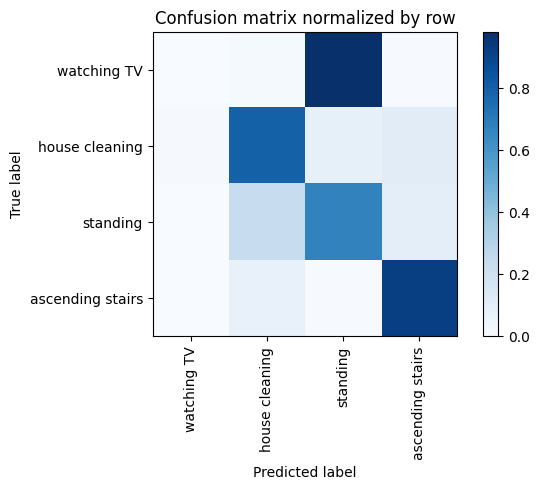

Overall accuracy: 0.660

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.558      0.669      0.608      0.330       1837|	 house cleaning: 0.237,	ascending stairs: 0.094,	
  house cleaning       0.736      0.796      0.765      0.329       1831|	 ascending stairs: 0.109,	standing: 0.084,	
ascending stairs       0.724      0.922      0.811      0.192       1071|	 house cleaning: 0.072,	standing: 0.007,	
     watching TV       0.000      0.000      0.000      0.149        829|	 standing: 0.982,	house cleaning: 0.013,	ascending stairs: 0.005,	

----------------------------------------------------------------------------------------------------
     avg / total       0.565      0.660      0.608        1.0       5568|	      

{'accuracy': 0.6596623563218391, 'precision': 0.5042720321297396, 'recall': 0.5965835613533023, 'f1': 0.5458929013292916, 'samples': 5568, 'loss': 2551631.544921875, 'feat. loss': 2551630.892578125, '

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.427



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.591



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.726



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.858



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.873



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.875



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.887



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.890



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.906



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.901



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.920



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.928



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.928



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.929



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.940



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.930



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.942



unseen:   0%|          | 0/86 [00:00<?, ?batch/s]

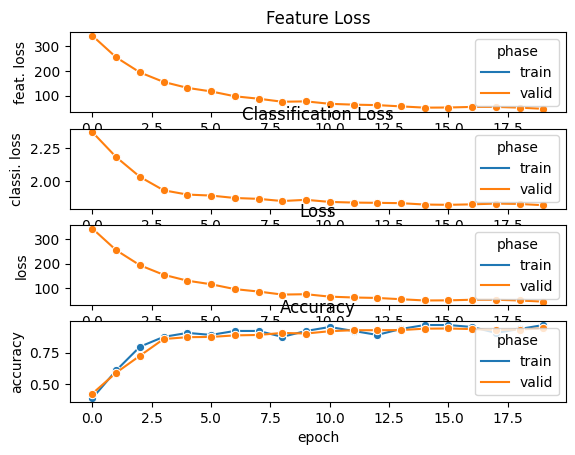

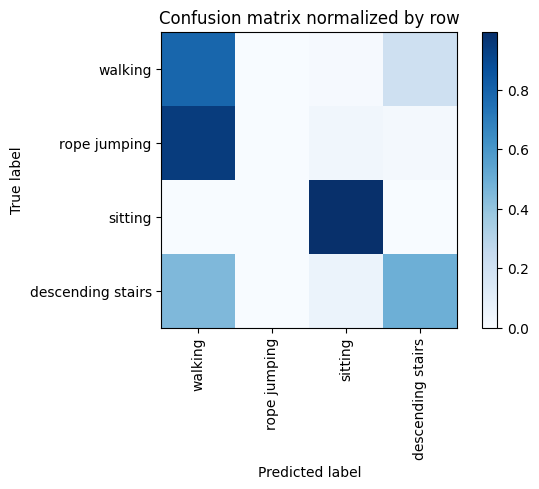

Overall accuracy: 0.739

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.680      0.786      0.729      0.420       2314|	 descending stairs: 0.203,	sitting: 0.011,	
          sitting       0.949      0.996      0.972      0.325       1790|	 descending stairs: 0.003,	walking: 0.001,	
descending stairs       0.488      0.493      0.490      0.171        942|	 walking: 0.448,	sitting: 0.059,	
     rope jumping       0.000      0.000      0.000      0.083        458|	 walking: 0.945,	sitting: 0.033,	descending stairs: 0.022,	

----------------------------------------------------------------------------------------------------
      avg / total       0.678      0.739      0.706        1.0       5504|	      

{'accuracy': 0.7385537790697675, 'precision': 0.529262182789026, 'recall': 0.5685461075487911, 'f1': 0.5477977620243334, 'samples': 5504, 'loss': 2251971.716796875, 'feat. loss': 2251971.080078125, 'classi. loss': 5

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.227



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.407



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.698



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.733



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.816



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.840



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.830



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.848



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.849



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.864



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.891



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.903



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.943



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.949



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.948



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.962



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.943



unseen:   0%|          | 0/111 [00:00<?, ?batch/s]

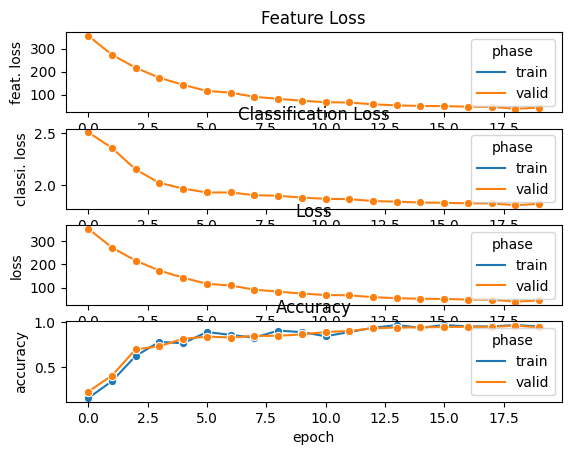

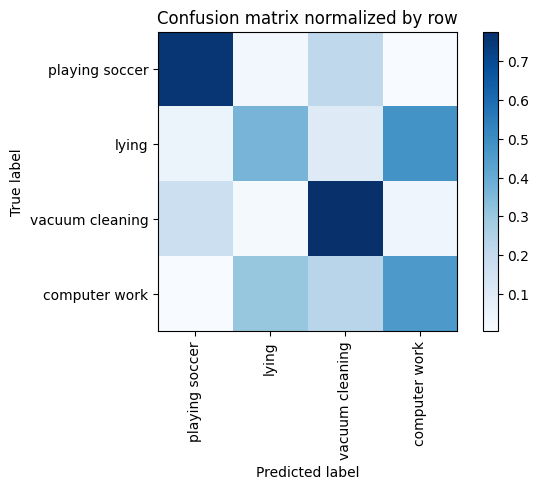

Overall accuracy: 0.531

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.594      0.461      0.519      0.432       3070|	 lying: 0.306,	vacuum cleaning: 0.229,	
          lying       0.414      0.367      0.389      0.264       1873|	 computer work: 0.481,	vacuum cleaning: 0.100,	
vacuum cleaning       0.572      0.776      0.659      0.240       1705|	 playing soccer: 0.171,	computer work: 0.039,	
 playing soccer       0.463      0.757      0.575      0.064        456|	 vacuum cleaning: 0.215,	lying: 0.024,	

----------------------------------------------------------------------------------------------------
    avg / total       0.533      0.531      0.522        1.0       7104|	      

{'accuracy': 0.5308277027027027, 'precision': 0.510642378261436, 'recall': 0.5901923063719622, 'f1': 0.5353118121083339, 'samples': 7104, 'loss': 3487414.43359375, 'feat. loss': 3487413.505859375, 'classi. loss': 8374.53931427002, 'N'

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.256



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.694



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.775



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.806



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.819



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.822



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.810



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.838



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.840



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.855



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.864



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.912



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.921



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.926



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.943



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.939



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.944



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.950



unseen:   0%|          | 0/68 [00:00<?, ?batch/s]

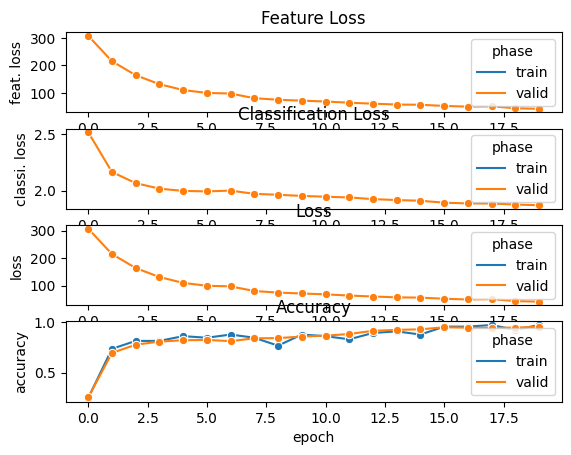

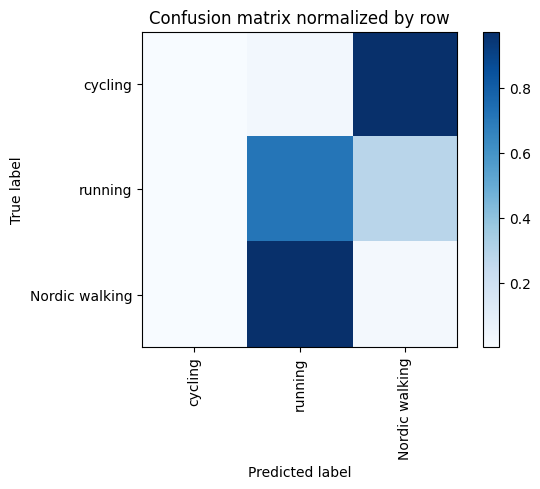

Overall accuracy: 0.165

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.024      0.025      0.024      0.418       1819|	 running: 0.973,	cycling: 0.003,	
       cycling       0.533      0.005      0.010      0.367       1597|	 Nordic walking: 0.970,	running: 0.025,	
       running       0.269      0.713      0.391      0.215        936|	 Nordic walking: 0.285,	cycling: 0.002,	

----------------------------------------------------------------------------------------------------
   avg / total       0.264      0.165      0.098        1.0       4352|	      

{'accuracy': 0.16544117647058823, 'precision': 0.2756333293497811, 'recall': 0.2474516992425347, 'f1': 0.14178503879803556, 'samples': 4352, 'loss': 2850276.640625, 'feat. loss': 2850276.0625, 'classi. loss': 5510.780624389648, 'N': 3}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4,

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.258



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.572



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.708



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.788



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.813



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.846



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.846



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.857



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.858



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.852



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.890



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.899



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.925



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.939



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.955



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.956



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.950



unseen:   0%|          | 0/60 [00:00<?, ?batch/s]

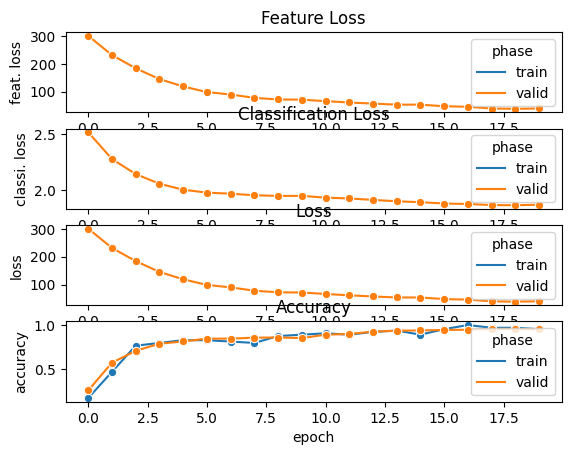

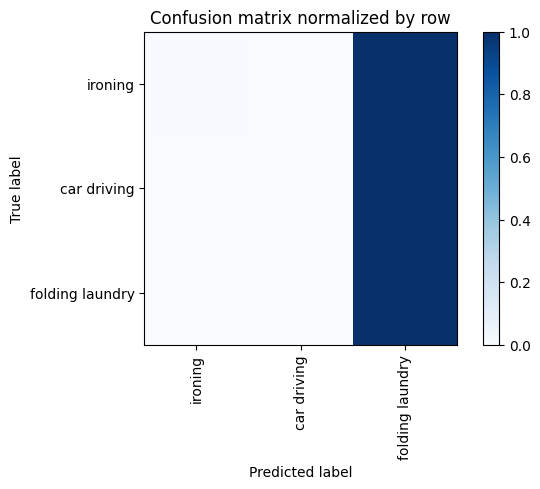

Overall accuracy: 0.257

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       1.000      0.007      0.014      0.607       2330|	 folding laundry: 0.993,	car driving: 0.000,	
folding laundry       0.254      0.997      0.404      0.253        972|	 car driving: 0.003,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.140        538|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.671      0.257      0.111        1.0       3840|	      

{'accuracy': 0.25677083333333334, 'precision': 0.4178883071553228, 'recall': 0.33473657252865646, 'f1': 0.13963687289259022, 'samples': 3840, 'loss': 2615756.73828125, 'feat. loss': 2615756.03125, 'classi. loss': 4930.800086975098, 'N': 3}
============== Overall Unseen Classes Performance ==============
accuracy     0.499045
precision    0.458737
recall 

In [ ]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['seq_len'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)

    # build model
    imu_config = {
        'in_ft':in_ft,
        'd_model':config['d_model'],
        'num_heads':config['num_heads'],
        'ft_size':config['feat_size'],
        'max_len':seq_len,
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'constrastive': nn.TripletMarginLoss(margin=0.5, p=1, reduction='none'), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):

        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())

    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
log('global', '',final_results.to_dict())
run.stop()
